In [ ]:
from google.colab import files
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Upload your zip if not already there
if not os.path.exists("Datas1"):
    files.upload() # Uncomment if you need to upload again
    !unzip -q "Datas1 (2).zip"

print("Dataset ready.")
!ls Datas1/train

Saving Datas1 (2).zip to Datas1 (2).zip
Dataset ready.
Bridge	Clean  CMP_scratch  Cracks  LER  Malformed_Via	Opens  Others


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    # The layer tf.keras.layers.RandomResizedCrop is not available in this TensorFlow version.
    # Replacing it with tf.keras.layers.RandomZoom to achieve a similar 'zoom in' effect.
    # height_factor=(-0.3, -0.1) means zooming in by 10% to 30%.
    tf.keras.layers.RandomZoom(height_factor=(-0.3, -0.1), fill_mode='reflect'),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
], name="augmentation")

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "Datas1/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Datas1/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Datas1/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 1671 files belonging to 8 classes.
Found 120 files belonging to 8 classes.
Found 120 files belonging to 8 classes.


In [ ]:
from tensorflow.keras import layers, models, applications

class SpatialAttentionModule(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        self.concat = layers.Concatenate(axis=-1)
        self.multiply = layers.Multiply()

    def call(self, input_feature):
        # Generates a mask that "turns off" boring background pixels
        avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
        concat = self.concat([avg_pool, max_pool])
        attention = self.conv(concat)
        return self.multiply([input_feature, attention])

from tensorflow.keras import layers, models, applications, regularizers

# Keep your SpatialAttentionModule class as it is!

def build_nxp_model(num_classes):
    # 1. Define L2 Regularization strength
    l2_reg = 0.001

    inputs = layers.Input(shape=(224, 224, 3))

    # Backbone: MobileNetV3Small
    base_model = applications.MobileNetV3Small(
        input_tensor=inputs,
        include_top=False,
        weights="imagenet"
    )

    # 2. CHANGE: Freeze the first 40 layers.
    # This prevents the model from forgetting basic shapes/edges while it learns your defects.
    base_model.trainable = True
    for layer in base_model.layers[:40]:
        layer.trainable = False

    x = base_model.output
    x = SpatialAttentionModule()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # 3. CHANGE: Add kernel_regularizer here
    x = layers.Dense(128,
                     activation="relu",
                     kernel_regularizer=regularizers.l2(l2_reg))(x)

    # 4. CHANGE: Increase Dropout from 0.3 to 0.5
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

model = build_nxp_model(NUM_CLASSES)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def focal_loss(gamma=2.0, alpha=0.25, label_smoothing=0.1): # <--- Add parameter here
    def focal_loss_fixed(y_true, y_pred):
        # 1. Apply Label Smoothing to y_true
        # This tells the model "90% sure it's this class, 10% spread across others"
        y_true = y_true * (1.0 - label_smoothing) + (label_smoothing / y_true.shape[-1])

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # 2. Standard Cross Entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # 3. Apply Focal Weighting
        # This keeps your fix for the Scratch vs Clean confusion
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss_fixed

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    # Pass the smoothing value here (0.1 is standard)
    loss=focal_loss(label_smoothing=0.1),
    metrics=['accuracy']
)

In [ ]:
checkpoint_path = "wafer_defect_final.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # Regularization allows for more epochs safely
    callbacks=callbacks
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 992ms/step - accuracy: 0.2199 - loss: 0.7754 - val_accuracy: 0.3000 - val_loss: 0.5570 - learning_rate: 1.0000e-04
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 424ms/step - accuracy: 0.5935 - loss: 0.4679 - val_accuracy: 0.5417 - val_loss: 0.4975 - learning_rate: 1.0000e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 426ms/step - accuracy: 0.7457 - loss: 0.3999 - val_accuracy: 0.6333 - val_loss: 0.4537 - learning_rate: 1.0000e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step - accuracy: 0.8065 - loss: 0.3731 - val_accuracy: 0.6750 - val_loss: 0.4260 - learning_rate: 1.0000e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 404ms/step - accuracy: 0.8433 - loss: 0.3603 - val_accuracy: 0.6750 - val_loss: 0.4092 - learning_rate: 1.0000e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - accuracy: 0.8848 - loss: 0.3471 - val_accuracy: 0.7083 - val_loss: 0.3982 - learning_rate: 1.0000e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 427ms/step - acc

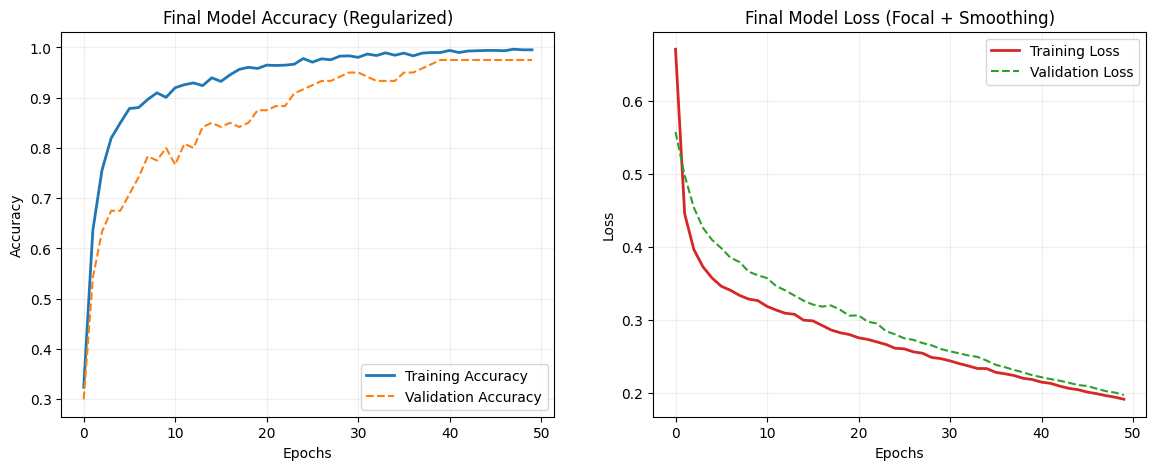

In [ ]:
import matplotlib.pyplot as plt

def plot_final_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='#1f77b4', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#ff7f0e', linestyle='--')
    plt.title('Final Model Accuracy (Regularized)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.2)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='#d62728', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='#2ca02c', linestyle='--')
    plt.title('Final Model Loss (Focal + Smoothing)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.2)

    plt.show()

plot_final_results(history)

Checking model performance on unseen test data...

FINAL CLASSIFICATION REPORT
               precision    recall  f1-score   support

       Bridge       1.00      1.00      1.00        16
  CMP_scratch       1.00      1.00      1.00        16
        Clean       1.00      1.00      1.00        15
       Cracks       1.00      1.00      1.00        10
          LER       1.00      1.00      1.00        14
Malformed_Via       1.00      1.00      1.00        19
        Opens       1.00      1.00      1.00         9
       Others       1.00      1.00      1.00        21

     accuracy                           1.00       120
    macro avg       1.00      1.00      1.00       120
 weighted avg       1.00      1.00      1.00       120



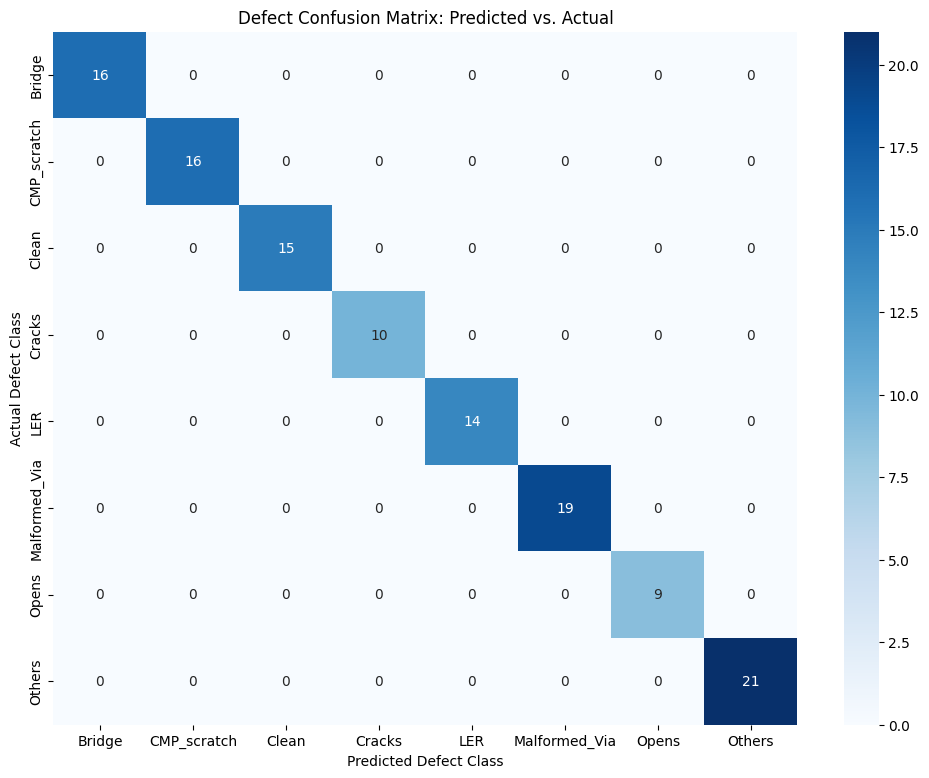

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate Predictions for the Test Set
# We use the test_ds which the model hasn't "seen" during training
print("Checking model performance on unseen test data...")
y_true = []
y_pred = []

for imgs, labels in test_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Print the Precision, Recall, and F1-Score
# Precision: When the model says 'Scratch', how often is it right?
# Recall: Out of all 'Scratches', how many did the model find?
print("\n" + "="*50)
print("FINAL CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Create a Visual Confusion Matrix

plt.figure(figsize=(12, 9))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Defect Confusion Matrix: Predicted vs. Actual")
plt.ylabel('Actual Defect Class')
plt.xlabel('Predicted Defect Class')
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_5']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


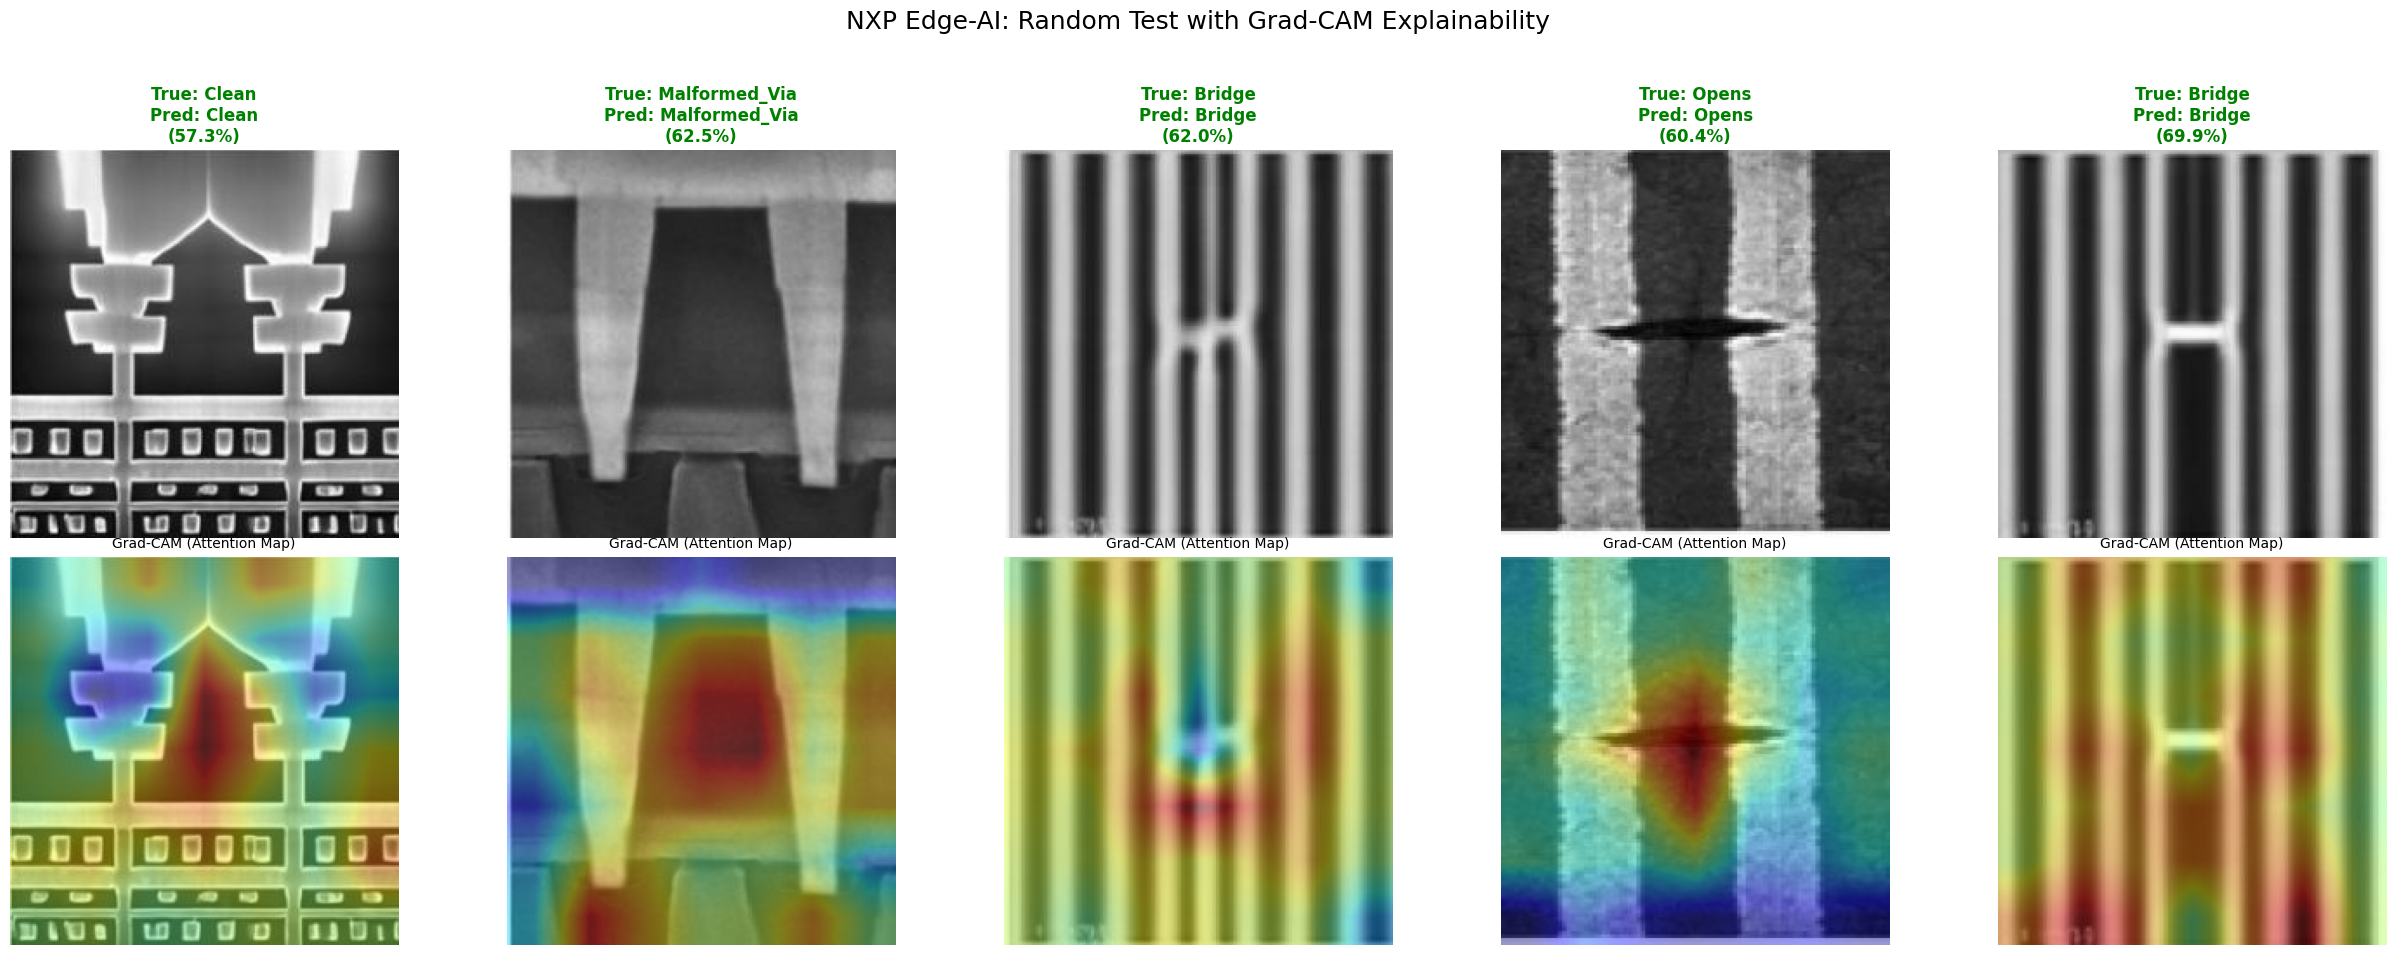

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import cv2

def get_gradcam_heatmap(img_array, model):
    """Generates the Grad-CAM heatmap for a specific image."""
    target_layer = None

    # First, try to get the 'mobilenet_v3_small' backbone
    try:
        base_model_wrapper = model.get_layer('mobilenet_v3_small')
        # Iterate through its sub-layers in reverse to find the last Conv2D or DepthwiseConv2D
        for layer in reversed(base_model_wrapper.layers):
            if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
                target_layer = layer
                break
    except ValueError:
        pass # 'mobilenet_v3_small' layer not found, fallback to searching main model layers

    # Fallback: if no layer found in backbone, search top-level model layers
    if target_layer is None:
        for layer in reversed(model.layers):
            if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
                target_layer = layer
                break

    if target_layer is None:
        raise ValueError("Could not find any suitable convolutional layer for Grad-CAM.")

    grad_model = tf.keras.models.Model(
        [model.inputs], [target_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def test_random_with_gradcam(model, dataset, class_names, num_images=4):
    # 1. Extract images and labels from the test dataset
    all_images = []
    all_labels = []

    for imgs, lbls in dataset.take(5):
        all_images.append(imgs.numpy())
        all_labels.append(lbls.numpy())

    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    indices = random.sample(range(len(all_images)), num_images)

    # 2. Setup Plot: 2 rows (Original and Grad-CAM)
    fig, axes = plt.subplots(2, num_images, figsize=(5 * num_images, 10))

    for i, idx in enumerate(indices):
        img = all_images[idx]
        img_batch = np.expand_dims(img, axis=0)

        # Normalize for display
        display_img = img.astype("float32")
        if display_img.max() > 1.0:
            display_img /= 255.0
        display_img = np.clip(display_img, 0, 1)

        # 3. Model Prediction
        preds = model.predict(img_batch, verbose=0)
        pred_idx = np.argmax(preds[0])
        true_idx = np.argmax(all_labels[idx])

        pred_label = class_names[pred_idx]
        true_label = class_names[true_idx]
        confidence = preds[0][pred_idx] * 100

        # 4. Generate Grad-CAM Heatmap - call without last_conv_name
        heatmap = get_gradcam_heatmap(img_batch, model)

        # Resize and overlay
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_color = plt.get_cmap("jet")(heatmap_resized)[:, :, :3]
        superimposed_img = (heatmap_color * 0.4) + (display_img * 0.6)
        superimposed_img = np.clip(superimposed_img, 0, 1)

        # 5. Plotting Original
        color = 'green' if true_label == pred_label else 'red'
        axes[0, i].imshow(display_img)
        axes[0, i].set_title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)",
                             color=color, fontweight='bold', fontsize=12)
        axes[0, i].axis('off')

        # 6. Plotting Grad-CAM
        axes[1, i].imshow(superimposed_img)
        axes[1, i].set_title(f"Grad-CAM (Attention Map)", fontsize=10)
        axes[1, i].axis('off')

    plt.suptitle("NXP Edge-AI: Random Test with Grad-CAM Explainability", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the test
# Tip: verify your last conv layer name via model.summary(). Usually 'Conv_1' for MobileNetV3.
test_random_with_gradcam(model, test_ds, class_names, num_images=5)


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 2,991,939 (11.41 MB)

 Trainable params: 987,763 (3.77 MB)

 Non-trainable params: 28,648 (111.91 KB)

 Optimizer params: 1,975,528 (7.54 MB)

In [ ]:
import tensorflow as tf
import time

# 1. Prepare a representative dataset for calibration (not strictly needed for float16 but harmless)
def representative_data_gen():
    # We take 100 samples from the training dataset
    for input_value, _ in train_ds.take(100):
        yield [input_value]

# 2. Convert to TFLite with FLOAT16 Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# For float16 quantization, set target_spec.supported_types
converter.target_spec.supported_types = [tf.float16]

tflite_model_float16 = converter.convert()

# 3. Save the model
with open("wafer_model_quant_float16.tflite", "wb") as f:
    f.write(tflite_model_float16)

print("Quantization Complete! Saved as: wafer_model_quant_float16.tflite")

Saved artifact at '/tmp/tmp4vo7gr12'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  136108662002448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662002640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662003600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662003216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662003408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662002832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662005136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662004944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662004560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662005712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662006

In [ ]:
import os
import time
import numpy as np

def get_tflite_latency(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()

    # Measure time over 100 iterations
    start_time = time.time()
    for _ in range(100):
        # Create random input matching the model's required type (int8 or float32)
        if input_details[0]['dtype'] == np.int8:
            test_input = np.random.randint(-128, 127, input_details[0]['shape'], dtype=np.int8)
        else:
            test_input = np.random.rand(*input_details[0]['shape']).astype(np.float32)

        interpreter.set_tensor(input_details[0]['index'], test_input)
        interpreter.invoke()
    end_time = time.time()

    return ((end_time - start_time) / 100) * 1000  # Returns average ms per image

# Calculate Stats
float16_latency = get_tflite_latency("wafer_model_quant_float16.tflite")
file_size = os.path.getsize("wafer_model_quant_float16.tflite") / (1024 * 1024) # MB

print(f"--- NXP DEPLOYMENT STATS ---")
print(f"Model Size: {file_size:.2f} MB")
print(f"Inference Latency: {float16_latency:.2f} ms / image")
print(f"Projected throughput: {1000/float16_latency:.1f} FPS")

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


--- NXP DEPLOYMENT STATS ---
Model Size: 1.95 MB
Inference Latency: 3.55 ms / image
Projected throughput: 281.8 FPS


In [ ]:
from google.colab import files

# This downloads the file we saved in the previous quantization step
files.download('wafer_model_quant_float16.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf

# 1. Setup the Converter for INT8 (Best for NXP)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Use a representative dataset to ensure accuracy isn't lost during INT8 conversion
def representative_data_gen():
    for input_value, _ in train_ds.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# 2. Convert and Save with the name we want
tflite_model_int8 = converter.convert()
with open("wafer_defect_int8.tflite", "wb") as f:
    f.write(tflite_model_int8)

print("✅ File 'wafer_defect_int8.tflite' has been created successfully!")

# 3. Now Download it
from google.colab import files
files.download('wafer_defect_int8.tflite')

Saved artifact at '/tmp/tmpakiu_1bq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  136108662002448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662002640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662003600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662003216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662003408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662002832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662005136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662004944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662004560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662005712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136108662006

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ File 'wafer_defect_int8.tflite' has been created successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
ydf 0.14.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which i

In [ ]:
import tf2onnx
import onnx
from google.colab import files

# 1. Define the input signature (matches your 224x224 input)
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)

# 2. Convert the model
# We save it to a temporary path first
output_path = "wafer_defect_model.onnx"

model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13, # Standard opset for high compatibility
    output_path=output_path
)

print(f"✅ ONNX model saved to {output_path}")

# 3. Download to your computer
files.download(output_path)

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7bc9aa88ea20>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ ONNX model saved to wafer_defect_model.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>